In [295]:
import pandas as pd
import tensorflow as tf

IMAGE_SIZE = 28
NUM_CLASSES = 10
BATCH_SIZE = 40

raw_train = pd.read_csv("fashion-mnist_train.csv")
raw_test = pd.read_csv("fashion-mnist_test.csv")

In [296]:
raw_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [297]:
def transform(raw_df):
    labels, images = raw_df.iloc[:, 0].values, raw_df.iloc[:, 1:].values
    return images, labels

In [298]:
train_x, train_y = transform(raw_train)
test_x, test_y = transform(raw_test)

<AxesSubplot:ylabel='Frequency'>

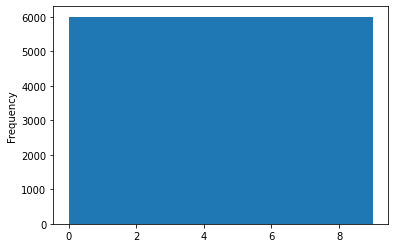

In [299]:
raw_train["label"].plot.hist()

In [300]:
def create_dataset(images, labels, training=True, reshape=True):
    if reshape:
        images = images.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)
    one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=NUM_CLASSES)
    ds = tf.data.Dataset.from_tensor_slices(((images), (one_hot_labels)))
    if training:
        ds = ds.shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size=BATCH_SIZE)
    return ds  

In [301]:
train_ds = create_dataset(train_x, train_y, reshape=False)
test_ds = create_dataset(test_x, test_y, reshape=False, training=False)

train_ds_cnn = create_dataset(train_x, train_y, reshape=True)
test_ds_cnn = create_dataset(train_x, train_y, reshape=True, training=False)

In [302]:
train_ds.take(1)

<TakeDataset shapes: ((None, 784), (None, 10)), types: (tf.int64, tf.float32)>

In [303]:
train_ds_cnn.take(1)

<TakeDataset shapes: ((None, 28, 28, 1), (None, 10)), types: (tf.int64, tf.float32)>

In [304]:
class DenseModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.encoders = [
            tf.keras.layers.Dense(units, activation=tf.nn.relu) for units in (1024, 512, 256)
        ]
        self.softmax = tf.keras.layers.Dense(NUM_CLASSES, activation=tf.nn.softmax)

    def call(self, inputs, training=True):
        hidden = self.encoders[0](inputs)
        for l in self.encoders[1:]:
            hidden = l(hidden)
        return self.softmax(hidden)
    


In [305]:
model = DenseModel()

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=["accuracy"]
)

In [306]:
model.fit(x=train_ds, use_multiprocessing=True, verbose=False, epochs=20)

In [307]:
model.evaluate(x=test_ds, batch_size=30)

250/250 [==============================] - 1s 3ms/step - loss: 1.7226 - accuracy: 0.1999


[1.7226057052612305, 0.19990000128746033]

In [369]:
class CNNModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.preprocess = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
        self.augmentation = tf.keras.Sequential([
          tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
          tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
        ])
        self.encoders = [
            tf.keras.layers.BatchNormalization(trainable=tf.keras.backend.learning_phase()),
            tf.keras.layers.Conv2D(8, 2),
            tf.keras.layers.BatchNormalization(trainable=tf.keras.backend.learning_phase()),
            tf.keras.layers.Activation("relu"),
            tf.keras.layers.Conv2D(16, 3),
            tf.keras.layers.BatchNormalization(trainable=tf.keras.backend.learning_phase()),
            tf.keras.layers.Activation("relu"),
            tf.keras.layers.Conv2D(32, 3),
            tf.keras.layers.BatchNormalization(trainable=tf.keras.backend.learning_phase()),
            tf.keras.layers.Activation("relu"),
            tf.keras.layers.Conv2D(64, 3),
            tf.keras.layers.BatchNormalization(trainable=tf.keras.backend.learning_phase()),
            tf.keras.layers.Activation("relu"),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Conv2D(128, 2),
            tf.keras.layers.BatchNormalization(trainable=tf.keras.backend.learning_phase()),
            tf.keras.layers.Activation("relu"),
            tf.keras.layers.MaxPooling2D(),
            
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Flatten()
        ]
        self.logits = tf.keras.layers.Dense(32, activation='relu')
        self.softmax = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")

    def call(self, inputs, training=True):
        inputs = self.preprocess(inputs)
        if training: 
            inputs = self.augmentation(inputs)
        
        hidden = self.encoders[0](inputs)
        for layer in self.encoders[1:]:
            hidden = layer(hidden)
        logits = self.logits(hidden)
        return self.softmax(logits)

In [370]:
cnn_model = CNNModel()
cnn_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0033),
    metrics=["accuracy"]
)

In [372]:
cnn_model.fit(x=train_ds_cnn, use_multiprocessing=True, epochs=25, verbose=1)
cnn_model.summary()

Epoch 1/25
1500/1500 [==============================] - 117s 78ms/step - loss: 0.9385 - accuracy: 0.6552
Epoch 2/25
1500/1500 [==============================] - 120s 80ms/step - loss: 0.7276 - accuracy: 0.7336
Epoch 3/25
1500/1500 [==============================] - 122s 81ms/step - loss: 0.6609 - accuracy: 0.7588
Epoch 4/25
1500/1500 [==============================] - 126s 84ms/step - loss: 0.6253 - accuracy: 0.7739
Epoch 5/25
1500/1500 [==============================] - 117s 78ms/step - loss: 0.5961 - accuracy: 0.7864
Epoch 6/25
1500/1500 [==============================] - 166s 111ms/step - loss: 0.5821 - accuracy: 0.7904
Epoch 7/25
1500/1500 [==============================] - 176s 117ms/step - loss: 0.5728 - accuracy: 0.7935
Epoch 8/25
1500/1500 [==============================] - 167s 111ms/step - loss: 0.5567 - accuracy: 0.8004
Epoch 9/25
1500/1500 [==============================] - 146s 97ms/step - loss: 0.5531 - accuracy: 0.8015
Epoch 10/25
1500/1500 [=============================

KeyboardInterrupt: 

In [364]:
cnn_model.evaluate(x=test_ds_cnn, batch_size=30)

1500/1500 [==============================] - 10s 6ms/step - loss: 0.4294 - accuracy: 0.8490


[0.4293837249279022, 0.8489833474159241]